In [1]:
import numpy as np
# import pandas as pd
import torch
import torch.nn as nn
import torchvision
%matplotlib widget
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib.colors as mcolors
import seaborn as sns
from tqdm.notebook import tqdm
# from dataclasses import dataclass
import os
sns.set()

In [2]:
batch_size = 120
learning_rate = 0.01

torch.manual_seed(0)

In [61]:
transforms = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize((0.1307,), (0.3081,)),
                    # torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
                torchvision.transforms.Lambda(lambda x: x.flatten())])

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.CIFAR10('./cifar10/', train=True, download=True, transform=transforms), 
        batch_size=batch_size, shuffle=True, pin_memory=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.CIFAR10('./cifar10/', train=False, download=True, transform=transforms), 
        batch_size=batch_size, shuffle=True, pin_memory=True)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
colors = list(mcolors.TABLEAU_COLORS)

def setup_axis(ax, num_epochs, r, title, data_shape, weights=False):
    ax.set_xlim(0, num_epochs - 1)
    # ax.set_ylim(r[0], r[1])
    ax.set_title(title)
    
    if weights:
        d = np.empty(data_shape)
        d[:] = np.nan
        data = {}
        for s in ['mean', 'std', 'max', 'min']:
            data[s] = d.copy()
        plot = []
        legend_elements = []
        for i in range(data_shape[1]):
            label = f'Layer {i}'
            mean_line = ax.plot(data['mean'][:,i], label=label, c=colors[i])[0]
            max_line = ax.plot(data['max'][:,i], c=colors[i], dashes=[6,2])[0]
            min_line = ax.plot(data['min'][:,i], c=colors[i], dashes=[6,2])[0]
            plot.append((mean_line, max_line, min_line))
            legend_elements.append(Patch(facecolor=colors[i], label=label))

        ax.legend(handles=legend_elements, loc='upper right')
        
    else:
        data = np.empty(data_shape)
        data[:] = np.nan
        plot = ax.plot(data)
    
    return data, plot

def log_data(data, new_data, epoch):
    data['mean'][epoch] = [torch.mean(layer).cpu() for layer in new_data]
    data['std'][epoch] = [torch.std(layer).cpu() for layer in new_data]
    data['max'][epoch] = [torch.max(layer).cpu() for layer in new_data]
    data['min'][epoch] = [torch.min(layer).cpu() for layer in new_data]

def set_axis_data(ax, p, data, data_std, num_epochs):
        ax.collections.clear()
        
        if type(data) == dict:
            for i, line_set in enumerate(p):
                for j, name in enumerate(['mean', 'max', 'min']):
                    line_set[j].set_ydata(data[name][:,i])
                ax.fill_between(range(num_epochs), data['mean'][:,i] - data['std'][:,i], data['mean'][:,i] + data['std'][:,i], color=colors[i], alpha=0.2)
        else:
            p[0].set_ydata(data)
            ax.fill_between(range(num_epochs), data - (data_std * 3), data + (data_std * 3), alpha=0.2)
            
        ax.relim()
        ax.autoscale()
        ax.set_xlim(0, num_epochs - 1)

In [5]:
weights = None
activations = None

def train(net, train_loader, num_epochs, test_loader=None):
    
    global weights, activations
    
    criterion = nn.CrossEntropyLoss()
    
    plt.close('all')
    fig, axes = plt.subplots(1, 3, figsize=(15, 3))
    hfig = display(fig, display_id=True)
    
    weights, weights_plot = setup_axis(axes[0], num_epochs, (-0.2, 0.2), "Weights", (num_epochs, len(net.weights)), True)
    accuracies, accuracies_plot = setup_axis(axes[2], num_epochs, (0, 1.1), "Accuracy", (num_epochs))
    accuracies_stds = accuracies.copy()
    activations, activations_plot = setup_axis(axes[1], num_epochs, (-1, 1), "Activations", (num_epochs, len(net.activations)), True)
    
    with torch.no_grad():
        
        weights_df = None
        activations_df = None
    
        for epoch in tqdm(range(num_epochs), desc="Epoch"):
            with tqdm(total=len(train_loader) + len(test_loader), leave=False, desc="Batch") as pbar:
                running_loss = 0
                
                for batch_idx, (data, targets) in enumerate(train_loader):
                    
                    if torch.cuda.is_available():
                        data = data.to('cuda')
                        targets = targets.to('cuda')

                    y = net(data)

                    one_hot = nn.functional.one_hot(targets, num_classes=10)
                    
                    net.update(data, y - one_hot)

                    running_loss += criterion(y, targets) / data.shape[0]
                    pbar.update(1)
                        
                log_data(weights, net.weights, epoch)
                log_data(activations, net.activations, epoch)
                
                test_means = np.zeros(len(test_loader))

                for batch_idx, (data, targets) in enumerate(test_loader):
                    
                    if torch.cuda.is_available():
                        data = data.to('cuda')
                        targets = targets.to('cuda')
                    
                    test_means[batch_idx] = torch.mean((targets == torch.argmax(net(data), axis=1)).float()).cpu()
                    pbar.update(1)

                accuracies[epoch] = np.mean(test_means)
                accuracies_stds[epoch] = np.std(test_means)
                
                set_axis_data(axes[0], weights_plot, weights, None, num_epochs)
                set_axis_data(axes[2], accuracies_plot, accuracies, accuracies_stds, num_epochs)
                set_axis_data(axes[1], activations_plot, activations, None, num_epochs)

                fig.canvas.draw()
                hfig.update(fig)

In [74]:
@torch.no_grad()
def generate_layer(in_size, out_size):
    w = nn.Linear(in_size, out_size, bias=False)
    a = nn.ReLU()
    
    layer_limit = np.sqrt(6.0 / in_size)
    torch.nn.init.kaiming_uniform_(w.weight, mode='fan_in', nonlinearity='relu')
    
    return nn.Sequential(w, a)

@torch.no_grad()
def collect_activations(model, l):
    def hook(self, input, output):
        model.activations[l] = output.detach()
    return hook

def generate_B(n_in, B_mean_zero=True, Bstd=0.05):
    
    n_out = 10
    sd = np.sqrt(6 / n_in)
    if B_mean_zero:
        B = (torch.rand(n_in, n_out) * 2 * sd - sd) * Bstd  # mean zero
    else:
        B = (torch.rand(n_in, n_out) * sd) * Bstd
        
    return B if not torch.cuda.is_available() else B.to('cuda')

class FCNet(nn.Module):

    @torch.no_grad()
    def __init__(self, layer_sizes, final_layer=True, B_mean_zero=True, Bstd=0.05):
        super(FCNet, self).__init__()
        self.layers_list = [generate_layer(in_size, out_size) for in_size, out_size in zip(layer_sizes, layer_sizes[1:-1])]
        self.layers_list.append(nn.Sequential(nn.Linear(layer_sizes[-2], layer_sizes[-1], bias=False), nn.Softmax(dim=1) if final_layer else nn.ReLU()))
        
        self.layers = nn.Sequential(*self.layers_list)
        
        self.weights = [layer[0].weight for layer in self.layers]
        
        self.activations = [None] * len(self.layers)
        
        for l, layer in enumerate(self.layers):
            layer.register_forward_hook(collect_activations(self, l))
            
        self.B = generate_B(layer_sizes[0], B_mean_zero=True, Bstd=Bstd)
        
        if torch.cuda.is_available():
            self.to('cuda')
        
    @torch.no_grad()
    def get_activations(self):
        return [activations.clone() for activations in self.activations]
        
    @torch.no_grad()        
    def forward(self, x):
        return self.layers(x)

    @torch.no_grad()
    def update(self, x, e, first_block=True, last_block=True):
        
        if first_block:
            hl_err = x + (e @ self.B.T)
        else:
            hl_err = x
        
        forward_activations = self.get_activations()
        modulated_forward = self.forward(hl_err)
        modulated_activations = self.get_activations()
        
        for l, layer in enumerate(self.layers):
            if (l == len(self.layers) - 1) and last_block:
                dwl = e.T @ (modulated_activations[l - 1] if l != 0 else x)
                layer[0].weight -= learning_rate * dwl / batch_size
            # else:
            #     dwl = (forward_activations[l] - modulated_activations[l]).T @ (modulated_activations[l - 1] if l != 0 else hl_err)
            # layer[0].weight -= learning_rate * dwl / batch_size
            
        return modulated_forward
            
                   
class FCRes_Net(nn.Module):

    @torch.no_grad()
    def __init__(self, input_size, output_size, block_sizes, block_depth=3, B_mean_zero=True, Bstd=0.05):
        super(FCRes_Net, self).__init__()
        
        self.blocks = [FCNet([block] * (block_depth + 1), final_layer=False) for block in block_sizes]
        self.dim_maps = [FCNet([input_size, block_sizes[0]], final_layer=False)]
        self.dim_maps += ([FCNet([in_size, out_size], final_layer=False) for in_size, out_size in zip(block_sizes, block_sizes[1:])])
        self.dim_maps.append(FCNet([block_sizes[-1], output_size]))
        
        self.layers = []
        self._activations = []
        
        for dim_map, block in zip(self.dim_maps, self.blocks):
            self.layers += dim_map.layers
            self.layers += block.layers
            
            self._activations.append(dim_map.activations)
            self._activations.append(block.activations)
            
        self.layers += self.dim_maps[-1].layers
        self._activations.append(self.dim_maps[-1].activations)
        
        self.weights = [layer[0].weight for layer in self.layers]
        
    @property
    def activations(self):
        result = []
        list(map(lambda acts: result.extend(acts), self._activations))
        return result
        
    def __repr__(self):
        res = ''
        for b, (dim_map, block) in enumerate(zip(self.dim_maps, self.blocks)):
            res += f'Dim Map {b}\n'
            res += dim_map.__repr__()
            res += '\n'
            res += f'Block {b}\n'
            res += block.__repr__() + '\n'
        res += self.dim_maps[-1].__repr__()
        return res
    
#     def forward(self, x, last_block=False):
        
#         in_x = x
#         x = 0
        
#         for b, (dim_map, block) in enumerate(zip(self.dim_maps, self.blocks)):
#             in_x = dim_map(in_x + x)
#             x = block(in_x)
            
#         return self.dim_maps[-1](x)
    
#     def update(self, x, e):
        
#         in_hl_err = x + (e @ self.dim_maps[0].B.T)
#         hl_err = 0
        
#         for b, (dim_map, block) in enumerate(zip(self.dim_maps, self.blocks)):
#             in_hl_err = dim_map.update(in_hl_err + hl_err, e, True, False)
#             hl_err = block.update(in_hl_err, e, False, False)
            
#         self.dim_maps[-1].update(hl_err, e, False, True)

    def forward(self, x):
        
        for b, (dim_map, block) in enumerate(zip(self.dim_maps, self.blocks)):
            x = dim_map(x)
            x = block(x)
            
        return self.dim_maps[-1](x)
    
    def update(self, x, e):
        
        dim_map_in = x
        
        for b, (dim_map, block) in enumerate(zip(self.dim_maps, self.blocks)):
            block_in = dim_map.forward(dim_map_in)#, e, True, False)
            # dim_map_in = block.activations[-1]
            hl_err = block.forward(block_in)#, e, False, False)
            
        self.dim_maps[-1].update(hl_err, e, True, True)

In [75]:
net.activations[-1]

tensor([[0.1456, 0.2640, 0.0520,  ..., 0.0323, 0.1217, 0.2080],
        [0.1056, 0.0430, 0.0982,  ..., 0.2232, 0.0687, 0.0962],
        [0.3350, 0.1503, 0.0436,  ..., 0.0394, 0.0983, 0.1256],
        ...,
        [0.0483, 0.0333, 0.1621,  ..., 0.0846, 0.0483, 0.0221],
        [0.0610, 0.2336, 0.0277,  ..., 0.0575, 0.0700, 0.4710],
        [0.0266, 0.0397, 0.0779,  ..., 0.0265, 0.0240, 0.0193]],
       device='cuda:0')

In [62]:
torch.mean(train_loader.dataset[10][0])

tensor(0.5149)

In [66]:
torch.mean(net.activations[3])

tensor(0.9668, device='cuda:0')

In [40]:
torch.std(net.dim_maps[1].B)

tensor(0.0022, device='cuda:0')

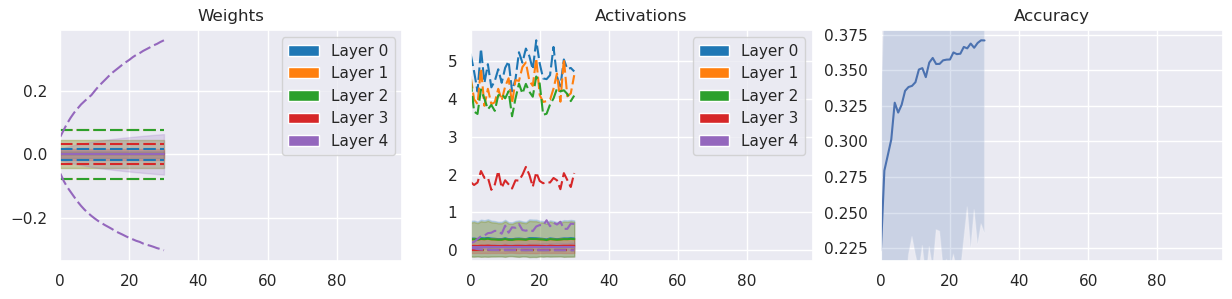

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Batch:   0%|          | 0/501 [00:00<?, ?it/s]

Batch:   0%|          | 0/501 [00:00<?, ?it/s]

Batch:   0%|          | 0/501 [00:00<?, ?it/s]

Batch:   0%|          | 0/501 [00:00<?, ?it/s]

Batch:   0%|          | 0/501 [00:00<?, ?it/s]

Batch:   0%|          | 0/501 [00:00<?, ?it/s]

Batch:   0%|          | 0/501 [00:00<?, ?it/s]

Batch:   0%|          | 0/501 [00:00<?, ?it/s]

Batch:   0%|          | 0/501 [00:00<?, ?it/s]

Batch:   0%|          | 0/501 [00:00<?, ?it/s]

Batch:   0%|          | 0/501 [00:00<?, ?it/s]

Batch:   0%|          | 0/501 [00:00<?, ?it/s]

Batch:   0%|          | 0/501 [00:00<?, ?it/s]

Batch:   0%|          | 0/501 [00:00<?, ?it/s]

Batch:   0%|          | 0/501 [00:00<?, ?it/s]

Batch:   0%|          | 0/501 [00:00<?, ?it/s]

Batch:   0%|          | 0/501 [00:00<?, ?it/s]

Batch:   0%|          | 0/501 [00:00<?, ?it/s]

Batch:   0%|          | 0/501 [00:00<?, ?it/s]

Batch:   0%|          | 0/501 [00:00<?, ?it/s]

Batch:   0%|          | 0/501 [00:00<?, ?it/s]

Batch:   0%|          | 0/501 [00:00<?, ?it/s]

Batch:   0%|          | 0/501 [00:00<?, ?it/s]

Batch:   0%|          | 0/501 [00:00<?, ?it/s]

Batch:   0%|          | 0/501 [00:00<?, ?it/s]

Batch:   0%|          | 0/501 [00:00<?, ?it/s]

Batch:   0%|          | 0/501 [00:00<?, ?it/s]

Batch:   0%|          | 0/501 [00:00<?, ?it/s]

Batch:   0%|          | 0/501 [00:00<?, ?it/s]

Batch:   0%|          | 0/501 [00:00<?, ?it/s]

Batch:   0%|          | 0/501 [00:00<?, ?it/s]

Batch:   0%|          | 0/501 [00:00<?, ?it/s]

In [ ]:
net = FCRes_Net(32 * 32 * 3, 10, [1024], block_depth=3)
# net = FCNet([32 * 32 * 3, 1024, 1024, 512, 512, 256, 256, 10], Bstd=0.05)
# net = FCNet([32 * 32 * 3, 1024, 10], Bstd=0.05)
d = train(net, train_loader, 100, test_loader)

In [ ]:
save_dir = '/home/cpsc490_ac2788/CPSC490/figures/report2/fig4/'
os.makedirs(save_dir, exist_ok=True)
plt.savefig(save_dir + "fig4.png")

In [ ]:
print(net)

In [ ]:
net = FCRes_Net(32 * 32 * 3, 10, [1000, 700, 500, 300])
train(net, train_loader, 10, test_loader)

In [ ]:
@dataclass
class ConvData:
    in_c: int
    out_c: int
    k_sz: int
    stride: int

class CNNNet(nn.Module):
    def __init__(self, conv_data, fc_layer_sizes, B_mean_zero=True, Bstd=0.05, output_dim=None):
        super(CNNNet, self).__init__()
        
        self.layers_list = [nn.Sequential(nn.Conv2d(cd.in_c, cd.out_c, cd.k_sz, stride=cd.stride, bias=False), nn.Tanh()) for cd in conv_data]
        self.unfolds = [nn.Unfold(cd.k_sz, stride=cd.stride) for cd in conv_data]
        self.layers_list.append(nn.Flatten())
        self.layers_list += [nn.Sequential(nn.Linear(in_size, out_size, bias=False), nn.Tanh()) for in_size, out_size in zip(fc_layer_sizes, fc_layer_sizes[1:])]
        
        self.layers = nn.Sequential(*self.layers_list)
        
        self.activations = [None] * len(self.layers)
        
        for l, layer in enumerate(self.layers):
            layer.register_forward_hook(collect_activations(self, l))
            
        self.B = generate_B(784, B_mean_zero=True, Bstd=0.05)
        
            
    def forward(self, x):
        return self.layers(x)
    
    def update(self, x, e, first_block=True, last_block=True):
        
        if first_block:
            print(x.shape, e.shape, self.B.T.shape, (e @ self.B.T).shape)
            hl_err = x + (e @ self.B.T)
        else:
            hl_err = x
        
        forward_activations = self.activations
        modulated_forward = self.forward(hl_err)
        modulated_activations = self.activations
        
        for l, layer in enumerate(self.layers):
            if (l == len(self.layers) - 1) and last_block:
                dwl = e.T @ (modulated_activations[l - 1] if l != 0 else x)
            else:
                dwl = (forward_activations[l] - modulated_activations[l]).T @ (modulated_activations[l - 1] if l != 0 else x)
            layer[0].weight -= learning_rate * dwl / batch_size
            
        return modulated_forward

In [ ]:
net = CNNNet([ConvData(1, 16, 7, 4), ConvData(16, 4, 2, 1)], [100, 10])
x = torch.rand(120, 1, 28, 28)
net(x)

In [ ]:
net.layers[0][0].weight += 

In [ ]:
net.activations[0].reshape(120, 1, 16, 36).shape

In [ ]:
torch.mean(net.activations[0].reshape(120, 1, 16, 36) * net.unfolds[0](x).reshape(120, 49, 1, 36), axis=(0, 1, 3))

In [ ]:
net.unfolds[0](x).reshape(120, 49, 1, 36).shape

In [ ]:
torch.mean(net.activations[0].reshape(120, 16, 36)[:,:1,:] * net.unfolds[0](x))

In [ ]:
net = FCRes_Net(784, 10, [1000, 700, 500, 300])
net